In [55]:
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import string
import warnings

from urllib.request import urlopen
from bs4 import BeautifulSoup as soup
from tqdm import tqdm
# from sklearn.decomposition import NMF, LatentDirichletAllocation, TruncatedSVD
# from sklearn.feature_extraction.text import CountVectorizer
# from sklearn.manifold import TSNE
from nltk.sentiment.vader import SentimentIntensityAnalyzer as SIA
# from pylab import bone, pcolor, colorbar, plot, show, rcParams, savefig

class coronavirus_news_aggregator():
    def __init__(self, client_list=[]):
        # Initialize Empty List
        self.client_list = client_list

    def covid19_news_scraper(self, search_query):
        """
        Pass in a client name or search query and returns last 100 headlines associating the client with Covid-19   
        """
        # Use this URL for Australian centric data
        news_url = "https://news.google.com.au/rss/search?q={"+str(search_query)+"%coronavirus}"
        Client = urlopen(news_url)
        xml_page = Client.read()
        Client.close()
        # Beautiful Soup Library is the bomb
        soup_page = soup(xml_page,"xml")
        news_list = soup_page.findAll("item")
        
        # Two separate lists for News Title and Publication Date
        l1 = []
        l2 = []
        for news in news_list:
            # Append to a list
            l1.append(news.title.text)
            l2.append(news.pubDate.text)
            # Zip the two together
            l_tup = list(zip(l1, l2))
        
        # Save this to a DataFrame
        df = pd.DataFrame(l_tup, columns=['Title', 'Date'])
        # Select Date of Headline
        df['Date'] = pd.to_datetime(df['Date']).dt.date
        # Split the Title into Headline and Source columns and then drop the 'Title' column
        df[['Headline','Source']] = df['Title'].str.rsplit("-",1,expand=True)
        df.drop('Title', axis=1, inplace=True)
        df['Client'] = str(search_query)
        return df

    def sentiment_analyser(self, search_query):
        """
        Runs a Google News Search on the input string and then uses VADER sentiment analysis engine on each returned headline.
        Input: Search Query String
        Output: DataFrame with compound sentiment score for each news article
        """
        # Create a Covid-19 News DataFrame for each organization of interest
        news_df = self.covid19_news_scraper(search_query)
        # Initialize VADER Sentiment Intensity Analyzer 
        sia = SIA()
        results = []

        # Calculate the polarity score for each headline associated with the organization
        for row in news_df['Headline']:
            pol_score = sia.polarity_scores(row)
            pol_score['Headline'] = row
            results.append(pol_score)
        
        # Create the Sentiment DataFrame
        sent_df = pd.DataFrame.from_records(results)
        # Merge the two dataframes together on the 'Headline' column
        merge_df = news_df.merge(sent_df, on='Headline')
        # Re-order and Rename the columns
        merge_df = merge_df.rename(columns={'compound':'VADER Score'})
        col_order = ['Client','Date','Headline','Source','VADER Score','neg','neu','pos']
        print('Completed processing %s' % search_query, "...")
        return merge_df[col_order]

    def client_c19_news_sentiment_agg(self, client_list):
        """
        Provided a list of clients, this pulls up the past 100 covid-19 related news articles on each of them and calculates 
        a Composite Sentiment score for each article related to a client 
        """
        frames = [self.sentiment_analyser(c) for c in client_list]
        result = pd.concat(frames)
        # print()
        # print("VADER Score is a Normalized Weighted Sentiment Composite Score that ranges from +1 (Extremely Positive) to -1 (Extremely Negative)")
        return result

if __name__ == "__main__":
    client_list = ['NAB','CBA','ANZ','Westpac']
    cn = coronavirus_news_aggregator()
    df = cn.client_c19_news_sentiment_agg(client_list=client_list)
    df.Date = pd.to_datetime(df.Date)
    print('Complete!')

Completed processing NAB ...
Completed processing CBA ...
Completed processing ANZ ...
Completed processing Westpac ...
Complete!


In [56]:
df.head()

,Client,Date,Headline,Source,VADER Score,neg,neu,pos
0,NAB,2020-04-30,"Commonwealth Bank home loan, NAB credit card r...",ABC News,0.1280,0.119,0.734,0.147
1,NAB,2020-04-30,NAB's latest coronavirus hardship measure thre...,Business Insider Australia,-0.6637,0.392,0.473,0.135
2,NAB,2020-04-30,NAB: Coronavirus impact could see house prices...,Savings.com.au,-0.2732,0.208,0.792,0.000
3,NAB,2020-04-20,NAB flags $1.14bn triple hit to H1 result,The West Australian,0.0000,0.000,1.000,0.000
4,NAB,2020-04-03,NAB expands coronavirus support to credit card...,Mozo.com.au,0.6908,0.000,0.544,0.456


In [57]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 400 entries, 0 to 99
Data columns (total 8 columns):
Client         400 non-null object
Date           400 non-null datetime64[ns]
Headline       400 non-null object
Source         400 non-null object
VADER Score    400 non-null float64
neg            400 non-null float64
neu            400 non-null float64
pos            400 non-null float64
dtypes: datetime64[ns](1), float64(4), object(3)
memory usage: 28.1+ KB


### Plot VADER Score by time for each client
---

In [58]:
df = df.groupby(['Date','Client'])['VADER Score'].agg('mean').to_frame().reset_index().set_index('Date')
df.head(10)

,Client,VADER Score
Date,,
2020-01-29,CBA,0.0000
2020-02-12,CBA,0.0516
2020-02-29,NAB,-0.2500
2020-03-02,CBA,0.2960
2020-03-03,CBA,0.2023
2020-03-09,CBA,-0.0900
2020-03-11,CBA,0.1280
2020-03-11,NAB,0.0000
2020-03-11,Westpac,-0.4215


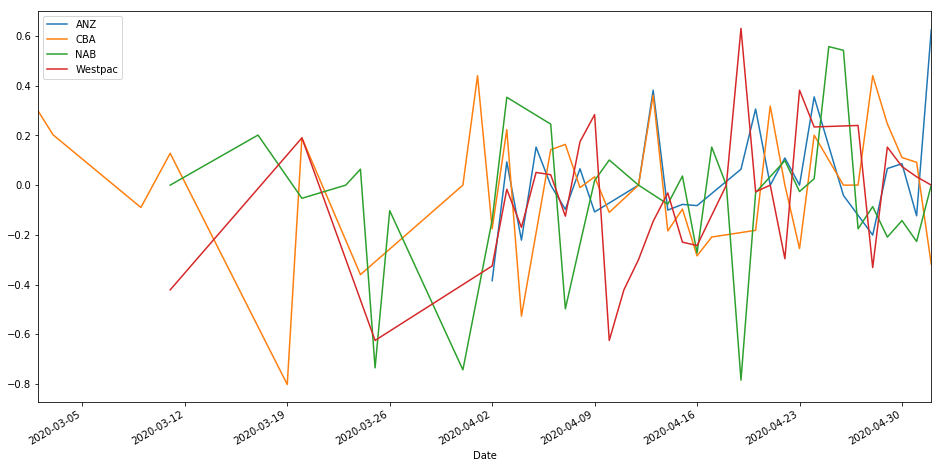

In [59]:
fig, ax = plt.subplots(figsize=(16,8))
df[df.index > '2020-03-01'].groupby("Client")["VADER Score"].plot(legend=True, ax=ax)
plt.show()